In [80]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
from scipy import integrate as integrate
import pandas as pd
from scipy.optimize import minimize
from scipy.special import erf
from matplotlib import cm
import scipy.integrate
from scipy import optimize
from scipy.integrate import odeint
from scipy import integrate as integrate
from scipy.interpolate import CubicSpline
from scipy.interpolate import lagrange

In [5]:
from getdist import plots, MCSamples
import getdist
import time

In [3]:
plt.style.use('default')
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

In [4]:
def E( parameters,z):  
    omega=parameters[0]
    alpha=parameters[1]
    #Ho= parameters[2]
    #print(alpha)
    sol = odeint (KG_eqn, y0(alpha), t, args=(parameters,))
    a=sol[:,0]
    phi=sol[:,1]
    phi_dot = sol[:,2]
    rho_m = 4.0/(9.0*(a**3))
    kappa_alpha = kappa(alpha)
    V = (1/2)*kappa_alpha/(phi)**(alpha)
    rho_phi = (1/32*np.pi)*(0.5*phi_dot**2 + V)
    omega_exp = rho_m/(rho_phi+rho_m)
    i = np.where(omega_exp>=omega)
    i=i[0]
    if (len(i)>1):
        i=i[-1]
    else:
        i=i[0]
    #print(i)
    rho_critical = rho_m[i]+rho_phi[i]
    a_z = 1/(1+z)
    #print(sol[i,0])
    a = a/sol[i,0]
    j = np.where(a >= a_z)[0]
    j=j[0]
    #print(j)
    omega_m_theo = rho_m[j]/(rho_critical)
    omega_phi_theo = rho_phi[j]/(rho_critical)
    return np.sqrt(omega_m_theo+omega_phi_theo)

In [106]:
def E_sol(rho_critical,rho_m,rho_phi,a,z):
    a_z = 1/(1+z)
    #print(sol[i,0])
    
    j = np.where(a >= a_z)[0]
    #print(j)
    if(len(j)>1):
        j=j[0]
    else:
        j=len(a)-1
    #print(j)
    omega_m_theo = rho_m[j]/(rho_critical)
    omega_phi_theo = rho_phi[j]/(rho_critical)
    return np.sqrt(omega_m_theo+omega_phi_theo)  

In [36]:
def erf_new(x):
    return ((4/np.pi)**(1/2))*(erf(x)-erf(0))

In [37]:
def alphaf(parameters,sigma_Ho,sigma,z,E_array):
    #sigma,z,H_obs are vectors

    n = len(sigma)
    alpha0=1/(sigma_Ho)**2
    for i in range(n):
        alpha0 = alpha0 + (E_array[i]/sigma[i])**2
        
    return alpha0

In [38]:
def beta(parameters,Ho,sigma_Ho,H_obs,sigma,z,E_array):
    n = len(sigma)
    beta0=Ho/((sigma_Ho)**2)
    for i in range(n):
        beta0 = beta0 + (E_array[i]*H_obs[i]/((sigma[i])**2))
        
    return beta0

In [39]:
def gamma(Ho,sigma_Ho,H_obs,sigma,E_array):
    n = len(sigma)
    gamma0=(Ho/(sigma_Ho))**2
    for i in range(n):
        gamma0 = gamma0 + (H_obs[i]/sigma[i])**2
        
    return gamma0 

In [86]:
def Likelihood(parameters,Ho,sigma_Ho,H_obs,sigma,z):
    omega=parameters[0]
    alpha=parameters[1]
    t_initial = 10**(-5)
    t_final = 150
    dt = 10**(-3)
    t = np.arange(0., t_final, dt)
    
    #print(y0(alpha))
    sol = odeint (KG_eqn, y0(alpha), t, args=(parameters,))
    
    a=sol[:,0]
    phi=sol[:,1]
    phi_dot = sol[:,2]
    rho_m = 4.0/(9.0*(a**3))
    kappa_alpha = kappa(alpha)
    V = (1/2)*kappa_alpha/(phi)**(alpha)
    rho_phi = (1/12)*(0.5*phi_dot**2 + V)
    omega_exp = rho_m/(rho_phi+rho_m)
    i = np.where(omega_exp>=omega)
    i=i[0]
    if (len(i)>1):
        i=i[-1]
    else:
        i=len(t)-1
    #print(i)
    rho_critical = rho_m[i]+rho_phi[i]
    a = a/sol[i,0]
    z_values = 1/a-1
    omega_m_theo=rho_m/rho_critical
    omega_phi_theo=rho_phi/rho_critical
    start = time.time()
    E_values = np.sqrt(omega_m_theo+omega_phi_theo)
    z_values = np.flipud(z_values)
    E_values = np.flipud(E_values)
    z_bw_0_1000 = np.where((z_values>=0) & (z_values<=50))
    z_bw_0_1000_values =z_values[z_bw_0_1000]
    E_bw_0_1000_values= E_values[z_bw_0_1000]
    #print(z_bw_0_1000_values)
    f = CubicSpline(z_bw_0_1000_values, E_bw_0_1000_values)
    end= time.time()
    #print(end-start)
    E_array= f(z_obs)
    alpha0= alphaf(parameters,sigma_Ho,sigma,z,E_array)
    beta0= beta(parameters,Ho,sigma_Ho,H_obs,sigma,z,E_array)
    gamma0= gamma(Ho,sigma_Ho,H_obs,sigma,E_array)
    LH1= (1/(4*alpha0*((sigma_Ho)**2)))**(1/2)
    LH2= np.exp(-gamma0/2+(((beta0)**2)/(2*alpha0)))
    LH3 = 1+ erf_new(beta0/((2*alpha0)**(1/2)))
    
    return (LH1*LH2*LH3)

In [41]:
def Chi_sq(parameters,Ho,sigma_Ho,H_obs,sigma,z):
    return (-2*np.log(Likelihood(parameters,Ho,sigma_Ho,H_obs,sigma,z)))

In [42]:
def log_likelihood(parameters,Ho,sigma_Ho,H_obs,sigma,z):
    return np.log(Likelihood(parameters,Ho,sigma_Ho,H_obs,sigma,z))

In [54]:
def log_prior(parameters):
    omega,alpha = parameters
    if 0.01 < omega < 2 and 10**(-5) < alpha < 5:
        return 0.0
    return -np.inf

In [44]:
def log_probability(parameters,Ho,sigma_Ho,H_obs,sigma,z):
    lp = log_prior(parameters)
    if not np.isfinite(lp):
        return -np.inf
   
    return lp + log_likelihood(parameters,Ho,sigma_Ho,H_obs,sigma,z)

In [15]:
print(E([0.30,0.01,70],1.965))

NameError: name 'KG_eqn' is not defined

In [15]:
def kappa(alpha):
    #print(alpha)
    #print(type(alpha))
    p1= (8*alpha+32)/(3*alpha+6)
    p2= ((2*(alpha**2)+4*alpha)/3)**(alpha/2)
    #print(f"kappa:{p1*p2}")
    return p1*p2

In [16]:
print(kappa(0.5))
print((1/12)*kappa(0.1)*0.13486911**(-0.1))

4.586125402580961
0.48047102316806106


In [17]:
def y0(alpha):
    t0 = 10**(-5)
    a_initial = (t0**(2/3))*(alpha)
    phi_initial =   ((2*alpha*(alpha+2)/3)**(1/2))*((t0)**(2/(alpha+2)))
   
    phi_dot_initial = (2/(alpha+2))*(phi_initial)/t0
    
    Ho = 70 # Hubble parameter today in units of 100 km/s/Mpc (Planck 2015)
    rho_cr0 = 3*Ho**2/(8*np.pi)
    #h = 0.678 # Hubble parameter today in units of 100 km/s/Mpc (Planck 2015)
    #rho_cr0 = 8.0992*(h**2)*10**(-47) / (2.435*10**18)**4
    # calculate the matter density today
    
    #Omega_m = 0.28
    #rho_m0 = Omega_m*rho_cr0
    #rho_initial = rho_m0/(a_initial**3) # initial value for the matter density
    
    return a_initial,phi_initial,phi_dot_initial
    #,rho_initial

In [18]:
print(y0(4))

(0.0018566355334451124, 0.08617738760127537, 2872.579586709179)


In [19]:
print(y0(np.array([0.01,0.02,0.03])))

(array([4.64158883e-06, 9.28317767e-06, 1.39247665e-05]), array([1.22582372e-06, 1.83928913e-06, 2.38866168e-06]), array([0.12197251, 0.18210783, 0.23533613]))


In [20]:
t_initial = 10**(-5)
t_final = 150
dt = t_initial
t = np.arange(0., t_final, dt)


    

In [75]:
def KG_eqn(y, t, parameters):
    #a,phi,phi_dot,rho_m = y
    a,phi,phi_dot = y
    rho_m = 4.0/(9.0*a**3)
    alpha=parameters[1]
    kappa_alpha = kappa(alpha)
    mp = 1
    V = (1/2)*kappa_alpha*mp**2/(phi)**(alpha)
    rho_phi = (1/6)*(0.5*phi_dot**2 + V)
    Hubble_rate = np.sqrt( (rho_phi + rho_m))
    #dydt = [a*Hubble_rate,phi_dot,-3*Hubble_rate*phi_dot+ 0.5*kappa_alpha*alpha/(phi**(alpha+1)), -3*rho_m*Hubble_rate ]
    dydt = [a*Hubble_rate,phi_dot,-3*Hubble_rate*phi_dot+ 0.5*kappa_alpha*alpha/(phi**(alpha+1)) ]
    return dydt

In [22]:
parameters = [0.30,0.01]
Ho=70

In [23]:
from scipy.integrate import odeint
#sol = odeint(KG_eqn, y0(0.01), t, args=(parameters,))
print(68.8*E(parameters,2.30))

233.22343602502858


In [40]:
print(sol[0:1678,2])

NameError: name 'sol' is not defined

In [41]:
a = sol[:,0]
phi=sol[:,1]
phi_dot=sol[:,2]
rho_m = sol[:,3]
H=[]
alpha = 0.01
print(phi,phi_dot,rho_m)
kappa_alpha = kappa(alpha)
V = (1/2)*kappa_alpha/(phi)**(alpha)
rho_phi = 0.5*phi_dot**2 + V
Hubble_rate = np.sqrt((8*np.pi/3)* (rho_phi + rho_m))
print(V)

print(Hubble_rate[16906])


NameError: name 'sol' is not defined

In [23]:
Data = pd.read_csv("Hdata - Table 1.csv")
print(Data)
Data = Data.to_numpy()
z_obs = Data[:,1]
H_obs = Data[:,2]
sigma_obs = Data[:,3]
print(z_obs)

    Unnamed: 0      z      H  Sigma
0          NaN  0.070   69.0   19.6
1          NaN  0.100   69.0   12.0
2          NaN  0.120   68.6   26.2
3          NaN  0.170   83.0    8.0
4          NaN  0.179   75.0    4.0
5          NaN  0.199   75.0    5.0
6          NaN  0.200   72.9   29.6
7          NaN  0.270   77.0   14.0
8          NaN  0.280   88.8   36.6
9          NaN  0.350   76.3    5.6
10         NaN  0.352   83.0   14.0
11         NaN  0.400   95.0   17.0
12         NaN  0.440   82.6    7.8
13         NaN  0.480   97.0   62.0
14         NaN  0.593  104.0   13.0
15         NaN  0.600   87.9    6.1
16         NaN  0.680   92.0    8.0
17         NaN  0.730   97.3    7.0
18         NaN  0.781  105.0   12.0
19         NaN  0.875  125.0   17.0
20         NaN  0.880   90.0   40.0
21         NaN  0.900  117.0   23.0
22         NaN  1.037  154.0   20.0
23         NaN  1.300  168.0   17.0
24         NaN  1.430  177.0   18.0
25         NaN  1.530  140.0   14.0
26         NaN  1.750  202.0

In [24]:
Ho= 68
sigma_Ho=2.8

In [87]:
start = time.time()
print(Chi_sq([0.25,0.001],73.8,2.4,H_obs,sigma_obs,z_obs))
end =time.time()
print(end-start)

20.51472393779039
0.06999468803405762


In [37]:
best_fit_params = minimize (Chi_sq,x0=[0.27,0.0001],args=(68,2.8,H_obs,sigma_obs,z_obs),method='L-BFGS-B',bounds=[(0,2),(0,5)])
print(best_fit_params)

<ipython-input-24-8d130fa533c9>:12: RuntimeWarning: invalid value encountered in double_scalars
  dydt = [a*Hubble_rate,phi_dot,-3*Hubble_rate*phi_dot+ 0.5*kappa_alpha*alpha/(phi**(alpha+1)) ]
<ipython-input-33-60a254515200>:14: RuntimeWarning: divide by zero encountered in true_divide
  rho_m = 4.0/(9.0*(a**3))
<ipython-input-33-60a254515200>:18: RuntimeWarning: invalid value encountered in true_divide
  omega_exp = rho_m/(rho_phi+rho_m)
<ipython-input-33-60a254515200>:27: RuntimeWarning: divide by zero encountered in true_divide
  a = a/sol[i,0]
<ipython-input-33-60a254515200>:27: RuntimeWarning: invalid value encountered in true_divide
  a = a/sol[i,0]
<ipython-input-11-2317c60a75cb>:2: RuntimeWarning: divide by zero encountered in log
  return (-2*np.log(Likelihood(parameters,Ho,sigma_Ho,H_obs,sigma,z)))


      fun: 18.71861206394749
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.        , 17.48856242])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 9
      nit: 1
     njev: 3
   status: 0
  success: True
        x: array([2.7e-01, 1.0e-04])


In [51]:
bfp = dict()
bfp['DA'] = optimize.dual_annealing(Chi_sq, [(0.01,2),(10**(-5),5)],args =(68,2.8,H_obs,sigma_obs,z_obs) )
print(bfp["DA"])

     fun: 18.074246326466472
 message: ['Maximum number of iteration reached']
    nfev: 4400
    nhev: 0
     nit: 1000
    njev: 133
  status: 0
 success: True
       x: array([2.87543335e-01, 1.00000000e-05])


In [52]:
start = time.time()
bfp2 = dict()
bfp2['DA'] = optimize.dual_annealing(Chi_sq, [(0.01,2),(10**(-5),5)],args =(73.8,2.4,H_obs,sigma_obs,z_obs) )
print(bfp2["DA"])
end = time.time()
print(end-start)
#print(bfp)
#print(np.round((bfp.x),2))
#print(np.round((bfp.fun),2))

     fun: 20.492412626107708
 message: ['Maximum number of iteration reached']
    nfev: 4307
    nhev: 0
     nit: 1000
    njev: 102
  status: 0
 success: True
       x: array([2.53516085e-01, 1.00000000e-05])
261.1854863166809


In [976]:
print(Chi_sq([0.29,0.0001],74,68,2.8,H_obs,sigma_obs,z_obs,N))

[ 46.73843358  49.07050131  50.6783947   54.90566107  55.70094723
  57.50942125  57.60135957  64.4505272   65.50272627  73.5063504
  73.75359464  79.74192816  84.73317609  89.72442402 103.82469943
 104.69816781 114.68066368 120.91972359 127.2835647  139.01299734
 139.63690333 142.1325273  159.22755146 192.0450066  208.26656238
 220.74468221 248.19654583 316.82620487]
263.60732117728344


<ipython-input-827-e42e0297d925>:5: RuntimeWarning: invalid value encountered in log
  P2= kappa(alpha)*(np.exp((-alpha)*np.log(phi)))/12
<ipython-input-885-3bf6cdf1d518>:7: RuntimeWarning: invalid value encountered in double_scalars
  dydt = [phi_pr,-(3.0 + HdotoH2)*phi_pr - kappa_alpha*(phi**(-alpha-1))/(2*Hsquared) ]
<ipython-input-827-e42e0297d925>:5: RuntimeWarning: divide by zero encountered in log
  P2= kappa(alpha)*(np.exp((-alpha)*np.log(phi)))/12
<ipython-input-827-e42e0297d925>:6: RuntimeWarning: overflow encountered in square
  P3= 1- ((phi_pr)**2)/12
<ipython-input-827-e42e0297d925>:7: RuntimeWarning: invalid value encountered in true_divide
  return (P1+P2)/P3
<ipython-input-964-14e45ff3c626>:7: RuntimeWarning: invalid value encountered in sqrt
  H_theo= np.sqrt(Hsq( parameters,Ho,phi,phi_pr,N))


In [968]:
z_initial = 2100
z_final = 0
N_initial = N_efolds(z_initial)
N_final = N_efolds(z_final)
timesteps = 5000
N = np.linspace(N_initial, N_final, timesteps)
redshifts =  np.exp(-N) - 1
print(redshifts[4000])

3.612682008024761


In [957]:
print(-2*np.log(0.09814992513745828))

4.642518241991984


In [63]:
print(2.36874500e-05**(-0.01))

1.1123842134671111


In [73]:
n=100
xlist = np.linspace(0, 0.60, n)
ylist = np.linspace(0.000001, 5, n)
parameters = np.meshgrid(xlist, ylist,sparse=True)
X=parameters[0]
Y=parameters[1]
Y=np.reshape(Y,(100))
print(Y.shape)

Z=Chi_sq((X,Y),68,2.8,H_obs,sigma_obs,z_obs)
Z=np.zeros((n,n))
for i in range(n):
    for  j in range (n):
        #print(X[i])
        Z[i,j]= Chi_sq((xlist[i],ylist[j]),68,2.8,H_obs,sigma_obs,z_obs)

(100,)


ValueError: Initial condition y0 must be one-dimensional.

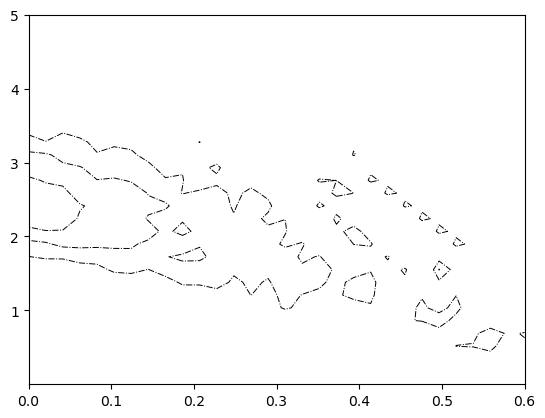

In [58]:
fig, ax1 = plt.subplots()

#drawing contour plot

cb = ax1.contour(X, Y, Z,levels=[17.63,19.93,23.80,28.71],colors="black",linewidths=0.7,linestyles="dashdot")

In [55]:
import emcee
from multiprocessing import Pool
pos = [2.87543335e-01, 1.00000000e-05] + 1e-4 * np.random.randn(100, 2)
nwalkers, ndim = pos.shape
print("done0")
filename = "Ho68_new_phiCDM.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)
print("done1")

#print(best_fit_params)
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(68,2.8,H_obs,sigma_obs,z_obs),backend=backend
)
start = time.time()
sampler.run_mcmc(pos, 10000, progress=True);
end = time.time()
print(end-start)

done0
done1


100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [12:09:16<00:00,  4.38s/it]

43759.77974176407


In [56]:
tau = sampler.get_autocorr_time()
print(tau)
#tau = sampler.get_autocorr_time()
burnin =  int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
flat_samples = sampler.get_chain(discard=burnin, thin=thin, flat=True)
print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("flat chain shape: {0}".format(flat_samples.shape))

[42.00656054 47.12242231]
burn-in: 94
thin: 21
flat chain shape: (47100, 2)


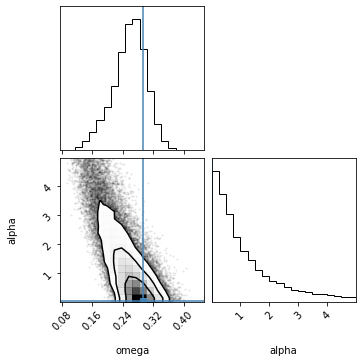

In [57]:
import corner
labels = ["omega","alpha"]
fig = corner.corner(
    flat_samples, labels=labels, truths= [0.29435933, 0.01217145]
);

In [64]:
from IPython.display import display, Math

for i in range(2):
    mcmc = np.percentile(flat_samples[:, i], [5, 50, 95])
    q = np.diff(mcmc)
    minimum = mcmc[1]-q[0]
    maximum = mcmc[1]+q[1]
    #print(f"{minimum} $\le \Omega \ge$ {maximum}")
    txt = "\mathrm{{{3}}} = {0:.2f}_{{{1:.2f}}}^{{{2:.2f}}}"
    txt = txt.format(mcmc[1], mcmc[1]-q[0], mcmc[1]+q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [59]:
#ndim = 2
#nsamp = 132400
samps = flat_samples
#samps2 = flat_samples2

In [60]:
names = ["omega","alpha"]
labels =  ["\Omega_{mo}","alpha"]
samples = MCSamples(samples=samps,names = names, labels = labels)
#samples2 = MCSamples(samples=samps2,names = names, labels = labels)

Removed no burn in


(0.0, 5.0)

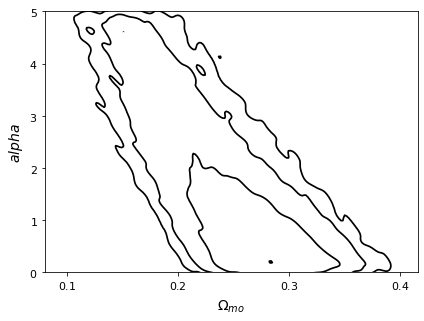

In [62]:
g = plots.get_single_plotter()
ax1= g.get_axes()
samples.updateSettings({'contours': [0.001,0.68, 0.95, 0.99]})
g.settings.num_plot_contours = 4
g.plot_2d(samples, 'omega', 'alpha');
ax1.set_ylim(0,5)


In [ ]:
import emcee
from multiprocessing import Pool
pos = [2.53516085e-01, 1.00000000e-05] + 1e-4 * np.random.randn(200, 2)
nwalkers, ndim = pos.shape
print("done0")
filename = "Ho73.8_phiCDM.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)
print("done1")

#print(best_fit_params)
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(73.8,2.4,H_obs,sigma_obs,z_obs),backend=backend
)
start = time.time()
sampler.run_mcmc(pos, 10000, progress=True);
end = time.time()
print(end-start)

done0
done1


 50%|███████████████████████████████████▋                                   | 5022/10000 [14:30:43<14:34:05, 10.54s/it]